In [1]:
import os
import sys
import pandas as pd
import glob
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import torch
import torch.nn as nn

plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
sns.set_style("ticks")

savefigs = True
pfp = '/home/as3837/'

In [2]:
dist_type = []
set_dist = []
for i in range(5): 
    x = torch.rand(500,1)
    set_dist.append(x)
    dist_type.append('Random')
    
for i in range(3): 
    m = torch.distributions.beta.Beta(torch.tensor([.5]), torch.tensor([.5]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Beta')
    
for i in range(3): 
    m = torch.distributions.beta.Beta(torch.tensor([.7]), torch.tensor([.3]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Beta')
    
for i in range(3): 
    m = torch.distributions.beta.Beta(torch.tensor([.2]), torch.tensor([.7]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Beta')
    
for i in range(5): 
    m = torch.distributions.exponential.Exponential(torch.tensor([1.5]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Exponential')
    
for i in range(5): 
    m = torch.distributions.exponential.Exponential(torch.tensor([2.5]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Exponential')
    
for i in range(5): 
    m = torch.distributions.gamma.Gamma(torch.tensor([1.0]), torch.tensor([1.5]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Gamma')
    
for i in range(3): 
    m = torch.distributions.laplace.Laplace(torch.tensor([1.0]), torch.tensor([1.5]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Laplace')
    
for i in range(3): 
    m = torch.distributions.laplace.Laplace(torch.tensor([.5]), torch.tensor([1.0]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Laplace')
    
for i in range(3): 
    m = torch.distributions.log_normal.LogNormal(torch.tensor([0.0]), torch.tensor([0.5]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('LogNormal')

    
for i in range(3): 
    m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    x = m.sample([500])
    set_dist.append(x)   
    dist_type.append('Normal')

for i in range(3): 
    m = torch.distributions.normal.Normal(torch.tensor([0.3]), torch.tensor([0.5]))
    x = m.sample([500])
    set_dist.append(x)  
    dist_type.append('Normal')
    
    
    
set_dist = torch.stack(set_dist)

In [3]:
set_dist.shape

torch.Size([44, 500, 1])

In [4]:
class DeepSet(nn.Module):

    def __init__(self, in_features, set_features):
        super(DeepSet, self).__init__()
        self.in_features = in_features
        self.out_features = set_features
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, 50),
            nn.ELU(inplace=True),
            nn.Linear(50, 100),
            nn.ELU(inplace=True),
            nn.Linear(100, set_features)
        )

        self.regressor = nn.Sequential(
            nn.Linear(set_features, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 10),
            nn.ELU(inplace=True),
            nn.Linear(10, 2),
        )
        
        
    def forward(self, input):
        x = input
        x = self.feature_extractor(x)
        x = x.sum(dim=1)
        x = self.regressor(x)
        return x
   

In [5]:
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).to(device).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).to(device).squeeze()

        u = torch.zeros_like(mu).to(device)
        v = torch.zeros_like(nu).to(device)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

      #  return cost, pi, C
        return cost

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=1):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepSet(1, 36).to(device)
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None).to(device)


model.load_state_dict(torch.load('deepset_dist_2conditions_5.pkl'))
model.eval()

DeepSet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=36, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=36, out_features=30, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [11]:
model_flat = DeepSet(1,36).to(device)
model_flat.load_state_dict(torch.load('deepset_dist_flat6.pkl'))
model_flat.eval()

DeepSet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=36, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=36, out_features=30, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [29]:
model1 = DeepSet(1,36).to(device)
model1.load_state_dict(torch.load('dist_encode_500epochs.pkl'))
model1.eval()


DeepSet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=36, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=36, out_features=30, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [15]:
results = pd.DataFrame()
euclidean_dist = []
wass_dist = []
dist_comparison = []

tic = time.time()
for i in range(len(set_dist)):
    for j in range(i+1,len(set_dist)):

        euclidean_dist.append((torch.norm(model(set_dist[i, :, :].view(1, -1, 1))-model(set_dist[j, :, :].view(1, -1, 1)), p=2)).item())
        wass_dist.append((sinkhorn(set_dist[i, :, :].view(1, -1, 1), set_dist[j, :, :].view(1, -1, 1))).item())
        dist_comparison.append('{}-{}'.format(dist_type[i], dist_type[j]))
    
    if i%50==0 and i!=0:
        print('... through {} iterations\t{:.2f}-s elapsed'.format(i+1, time.time()-tic))
        results = pd.DataFrame()
        results['Euclidean distance'] = euclidean_dist
        results['Wasserstein distance'] = wass_dist
        results['Comparisons'] = dist_comparison
        results.to_csv('results_w2.csv')

# store results
results = pd.DataFrame()
results['Euclidean distance'] = euclidean_dist
results['Wasserstein distance'] = wass_dist
results['Comparisons'] = dist_comparison
results.to_csv('results_w2.csv')

In [30]:
#Trying another model 
results = pd.DataFrame()
euclidean_dist = []
wass_dist = []
dist_comparison = []

tic = time.time()
for i in range(len(set_dist)):
    for j in range(i+1,len(set_dist)):

        euclidean_dist.append((torch.norm(model1(set_dist[i, :, :].view(1, -1, 1))-model1(set_dist[j, :, :].view(1, -1, 1)), p=2)).item())
        wass_dist.append((sinkhorn(set_dist[i, :, :].view(1, -1, 1), set_dist[j, :, :].view(1, -1, 1))).item())
        dist_comparison.append('{}-{}'.format(dist_type[i], dist_type[j]))
    
    if i%50==0 and i!=0:
        print('... through {} iterations\t{:.2f}-s elapsed'.format(i+1, time.time()-tic))
        results = pd.DataFrame()
        results['Euclidean distance'] = euclidean_dist
        results['Wasserstein distance'] = wass_dist
        results['Comparisons'] = dist_comparison
        results.to_csv('results_w2_1.csv')

# store results
results = pd.DataFrame()
results['Euclidean distance'] = euclidean_dist
results['Wasserstein distance'] = wass_dist
results['Comparisons'] = dist_comparison
results.to_csv('results_w2_1.csv')

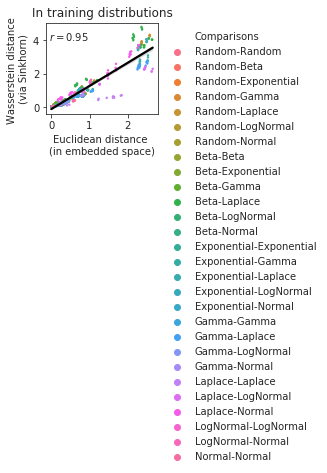

In [16]:
fname = 'w2'
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x='Euclidean distance',
                y='Wasserstein distance',
                hue='Comparisons',
                data=results,
                linewidth=0,
                s=6,
                alpha=1,
                ax=ax,
                rasterized=True)
sns.regplot(x='Euclidean distance', 
            y='Wasserstein distance', 
            data=results, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)
ax.legend(bbox_to_anchor=(1,1))

# correlation
r, p = stats.pearsonr(results['Euclidean distance'], results['Wasserstein distance'])
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.set_title('In training distributions')
ax.set_ylabel('Wasserstein distance \n(via Sinkhorn)', ha='center')
ax.set_xlabel('Euclidean distance \n(in embedded space)', ha='center')


if savefigs:
    fig.savefig('corr_plot_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

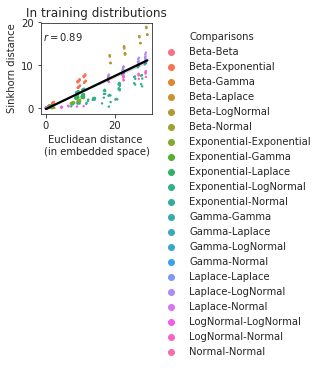

In [31]:
#Using the other model
fname = 'w2_1'
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x='Euclidean distance',
                y='Wasserstein distance',
                hue='Comparisons',
                data=results,
                linewidth=0,
                s=6,
                alpha=1,
                ax=ax,
                rasterized=True)
sns.regplot(x='Euclidean distance', 
            y='Wasserstein distance', 
            data=results, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)
ax.legend(bbox_to_anchor=(1,1))

# correlation
r, p = stats.pearsonr(results['Euclidean distance'], results['Wasserstein distance'])
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.set_title('In training distributions')
ax.set_ylabel('Sinkhorn distance', ha='center')
ax.set_xlabel('Euclidean distance \n(in embedded space)', ha='center')


if savefigs:
    fig.savefig('corr_plot_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

In [9]:
fname = 'scaling'

results = pd.DataFrame()
euclidean_dist = []
euclidean_dist_scaled = []
dist_comparison = []

tic = time.time()
for i in range(len(set_dist)):
    for j in range(i+1,len(set_dist)):
        
        xprime = torch.rand(1)

        euclidean_dist.append((xprime*(torch.norm(model(set_dist[i, :, :].view(1, -1, 1))-model(set_dist[j, :, :].view(1, -1, 1)), p=2))).item())
        euclidean_dist_scaled.append((torch.norm(model(set_dist[i, :, :].view(1, -1, 1)*xprime)-model(set_dist[j, :, :].view(1, -1, 1)*xprime), p=2)).item())
        dist_comparison.append('{}-{}'.format(dist_type[i], dist_type[j]))
    
    if i%50==0 and i!=0:
        print('... through {} iterations\t{:.2f}-s elapsed'.format(i+1, time.time()-tic))
        results = pd.DataFrame()
        results['Euclidean distance'] = euclidean_dist
        results['Scaled Euclidean distance'] = euclidean_dist_scaled
        results['Comparisons'] = dist_comparison
        results.to_csv('results_{}.csv'.format(fname))

# store results
results = pd.DataFrame()
results['Euclidean distance'] = euclidean_dist
results['Scaled Euclidean distance'] = euclidean_dist_scaled
results['Comparisons'] = dist_comparison
results.to_csv('results_{}.csv'.format(fname))

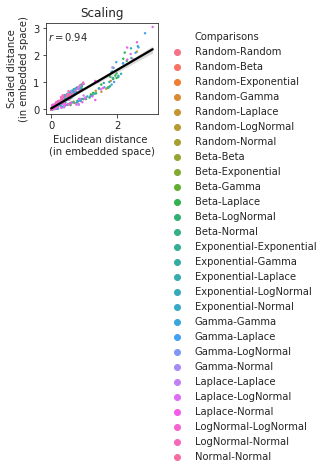

In [10]:
fname = 'Scaling'
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x='Euclidean distance',
                y='Scaled Euclidean distance',
                hue='Comparisons',
                data=results,
                linewidth=0,
                s=6,
                alpha=1,
                ax=ax,
                rasterized=True)
sns.regplot(x='Euclidean distance', 
            y='Scaled Euclidean distance', 
            data=results, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

# correlation
r, p = stats.pearsonr(results['Euclidean distance'], results['Scaled Euclidean distance'])
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_title(fname)
ax.set_ylabel('Scaled distance\n(in embedded space)', ha='center')
ax.set_xlabel('Euclidean distance \n(in embedded space)', ha='center')

if savefigs:
    fig.savefig('corr_plot_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

In [12]:
fname = 'scaling_flat'

results = pd.DataFrame()
euclidean_dist = []
euclidean_dist_scaled = []
dist_comparison = []

tic = time.time()
for i in range(len(set_dist)):
    for j in range(i+1,len(set_dist)):
        
        xprime = torch.rand(1)

        euclidean_dist.append((xprime*(torch.norm(model_flat(set_dist[i, :, :].view(1, -1, 1))-model_flat(set_dist[j, :, :].view(1, -1, 1)), p=2))).item())
        euclidean_dist_scaled.append((torch.norm(model_flat(set_dist[i, :, :].view(1, -1, 1)*xprime)-model_flat(set_dist[j, :, :].view(1, -1, 1)*xprime), p=2)).item())
        dist_comparison.append('{}-{}'.format(dist_type[i], dist_type[j]))
    
    if i%50==0 and i!=0:
        print('... through {} iterations\t{:.2f}-s elapsed'.format(i+1, time.time()-tic))
        results = pd.DataFrame()
        results['Euclidean distance'] = euclidean_dist
        results['Scaled Euclidean distance'] = euclidean_dist_scaled
        results['Comparisons'] = dist_comparison
        results.to_csv('results_{}.csv'.format(fname))

# store results
results = pd.DataFrame()
results['Euclidean distance'] = euclidean_dist
results['Scaled Euclidean distance'] = euclidean_dist_scaled
results['Comparisons'] = dist_comparison
results.to_csv('results_{}.csv'.format(fname))

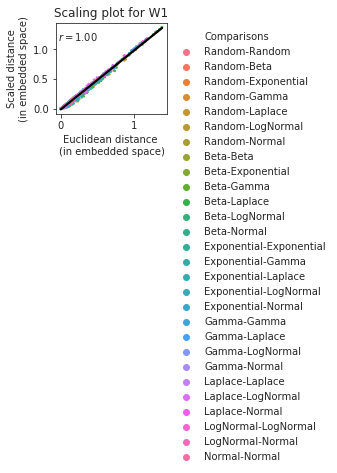

In [15]:
fname = 'Scaling plot for W1'
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x='Euclidean distance',
                y='Scaled Euclidean distance',
                hue='Comparisons',
                data=results,
                linewidth=0,
                s=6,
                alpha=1,
                ax=ax,
                rasterized=True)
sns.regplot(x='Euclidean distance', 
            y='Scaled Euclidean distance', 
            data=results, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

# correlation
r, p = stats.pearsonr(results['Euclidean distance'], results['Scaled Euclidean distance'])
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_title(fname)
ax.set_ylabel('Scaled distance\n(in embedded space)', ha='center')
ax.set_xlabel('Euclidean distance \n(in embedded space)', ha='center')

if savefigs:
    fig.savefig('corr_plot_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

In [17]:
fname = 'translation'

results = pd.DataFrame()
euclidean_dist = []
euclidean_dist_trans = []
dist_comparison = []

tic = time.time()
for i in range(len(set_dist)):
    for j in range(i+1,len(set_dist)):
        
        xprime = torch.rand(1)

        euclidean_dist.append((torch.norm(model(set_dist[i, :, :].view(1, -1, 1))-model(set_dist[j, :, :].view(1, -1, 1)), p=2)).item())
        euclidean_dist_trans.append((torch.norm(model(set_dist[i, :, :].view(1, -1, 1)+xprime)-model(set_dist[j, :, :].view(1, -1, 1)+xprime), p=2)).item())
        dist_comparison.append('{}-{}'.format(dist_type[i], dist_type[j]))
    
    if i%50==0 and i!=0:
        print('... through {} iterations\t{:.2f}-s elapsed'.format(i+1, time.time()-tic))
        results = pd.DataFrame()
        results['Euclidean distance'] = euclidean_dist
        results['Translated Euclidean distance'] = euclidean_dist_trans
        results['Comparisons'] = dist_comparison
        results.to_csv('results_{}.csv'.format(fname))

# store results
results = pd.DataFrame()
results['Euclidean distance'] = euclidean_dist
results['Translated Euclidean distance'] = euclidean_dist_trans
results['Comparisons'] = dist_comparison
results.to_csv('results_{}.csv'.format(fname))

In [32]:
#Using the other model
fname = 'translation_1'

results = pd.DataFrame()
euclidean_dist = []
euclidean_dist_trans = []
dist_comparison = []

tic = time.time()
for i in range(len(set_dist)):
    for j in range(i+1,len(set_dist)):
        
        xprime = torch.rand(1)

        euclidean_dist.append((torch.norm(model1(set_dist[i, :, :].view(1, -1, 1))-model1(set_dist[j, :, :].view(1, -1, 1)), p=2)).item())
        euclidean_dist_trans.append((torch.norm(model1(set_dist[i, :, :].view(1, -1, 1)+xprime)-model1(set_dist[j, :, :].view(1, -1, 1)+xprime), p=2)).item())
        dist_comparison.append('{}-{}'.format(dist_type[i], dist_type[j]))
    
    if i%50==0 and i!=0:
        print('... through {} iterations\t{:.2f}-s elapsed'.format(i+1, time.time()-tic))
        results = pd.DataFrame()
        results['Euclidean distance'] = euclidean_dist
        results['Translated Euclidean distance'] = euclidean_dist_trans
        results['Comparisons'] = dist_comparison
        results.to_csv('results_{}.csv'.format(fname))

# store results
results = pd.DataFrame()
results['Euclidean distance'] = euclidean_dist
results['Translated Euclidean distance'] = euclidean_dist_trans
results['Comparisons'] = dist_comparison
results.to_csv('results_{}.csv'.format(fname))

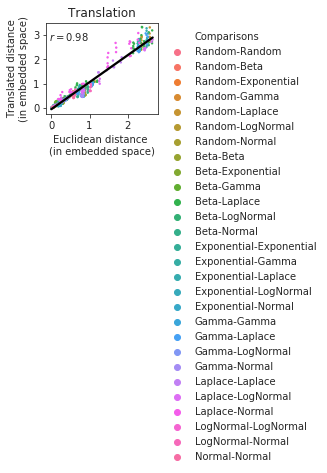

In [18]:
fname = 'Translation'
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x='Euclidean distance',
                y='Translated Euclidean distance',
                hue='Comparisons',
                data=results,
                linewidth=0,
                s=6,
                alpha=1,
                ax=ax,
                rasterized=True)
sns.regplot(x='Euclidean distance', 
            y='Translated Euclidean distance', 
            data=results, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

# correlation
r, p = stats.pearsonr(results['Euclidean distance'], results['Translated Euclidean distance'])
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_title(fname)
ax.set_ylabel('Translated distance\n(in embedded space)', ha='center')
ax.set_xlabel('Euclidean distance \n(in embedded space)', ha='center')

if savefigs:
    fig.savefig('corr_plot_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

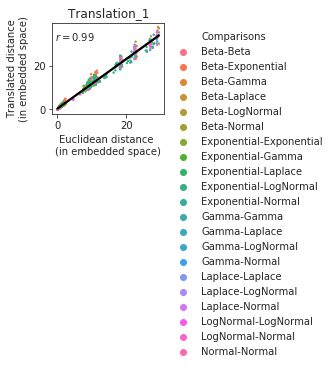

In [33]:
#Visualizing the results of the other model 
fname = 'Translation_1'
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x='Euclidean distance',
                y='Translated Euclidean distance',
                hue='Comparisons',
                data=results,
                linewidth=0,
                s=6,
                alpha=1,
                ax=ax,
                rasterized=True)
sns.regplot(x='Euclidean distance', 
            y='Translated Euclidean distance', 
            data=results, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

# correlation
r, p = stats.pearsonr(results['Euclidean distance'], results['Translated Euclidean distance'])
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_title(fname)
ax.set_ylabel('Translated distance\n(in embedded space)', ha='center')
ax.set_xlabel('Euclidean distance \n(in embedded space)', ha='center')

if savefigs:
    fig.savefig('corr_plot_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

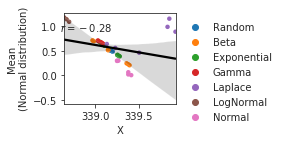

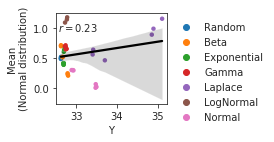

In [19]:
fname = 'Varying means'

euclidean_dist = []
euclidean_dist_trans = []
dist_comparison = []

mus = []
xy = np.empty((len(set_dist), 2))
for i in range(len(set_dist)):
    mus.append(set_dist[i, :, :].mean().item())
    xy[i, :] = model(set_dist[i, :, :].view(1, -1, 1)).detach().numpy()


# X
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x=xy[:,0],
                y=mus, 
                ax=ax,
                hue=dist_type,
                linewidth=0,
                s=20)

# correlation
r, p = stats.pearsonr(xy[:,0], mus)
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Mean\n(Normal distribution)', ha='center')
ax.set_xlabel('X')

sns.regplot(x=xy[:,0], 
            y=mus, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatterplotplot_X_{}.pdf'.format(fname)), dpi=600, bbox_inches='tight')
    
# Y    
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x=xy[:,1],
                y=mus, 
                ax=ax,
                hue=dist_type,
                linewidth=0,
                s=20)

# correlation
r, p = stats.pearsonr(xy[:,1], mus)
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Mean\n(Normal distribution)', ha='center')
ax.set_xlabel('Y')

sns.regplot(x=xy[:,1], 
            y=mus, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

if savefigs:
    fig.savefig('scatterplotplot_Y_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')


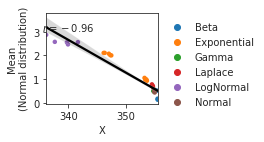

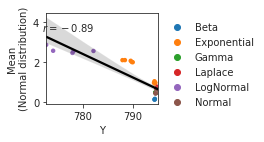

In [34]:
#Varying means with the other model
fname = 'Varying means_1'

euclidean_dist = []
euclidean_dist_trans = []
dist_comparison = []

mus = []
xy = np.empty((len(set_dist), 2))
for i in range(len(set_dist)):
    mus.append(set_dist[i, :, :].mean().item())
    xy[i, :] = model1(set_dist[i, :, :].view(1, -1, 1)).detach().numpy()


# X
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x=xy[:,0],
                y=mus, 
                ax=ax,
                hue=dist_type,
                linewidth=0,
                s=20)

# correlation
r, p = stats.pearsonr(xy[:,0], mus)
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Mean\n(Normal distribution)', ha='center')
ax.set_xlabel('X')

sns.regplot(x=xy[:,0], 
            y=mus, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatterplotplot_X_{}.pdf'.format(fname)), dpi=600, bbox_inches='tight')
    
# Y    
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x=xy[:,1],
                y=mus, 
                ax=ax,
                hue=dist_type,
                linewidth=0,
                s=20)

# correlation
r, p = stats.pearsonr(xy[:,1], mus)
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Mean\n(Normal distribution)', ha='center')
ax.set_xlabel('Y')

sns.regplot(x=xy[:,1], 
            y=mus, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

if savefigs:
    fig.savefig('scatterplotplot_Y_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')


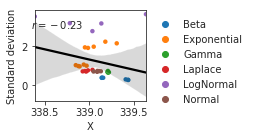

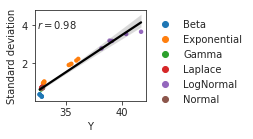

In [24]:
fname = 'Varying standard deviations'

sigmas = []
xy = np.empty((len(set_dist), 2))
for i in range(len(set_dist)):
    sigmas.append(set_dist[i, :, :].std().item())
    xy[i, :] = model(set_dist[i, :, :].view(1, -1, 1)).detach().numpy()


# X
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x=xy[:,0],
                y=sigmas, 
                ax=ax,
                hue=dist_type,
                linewidth=0,
                s=20)

# correlation
r, p = stats.pearsonr(xy[:,0], sigmas)
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Standard deviation', ha='center')
ax.set_xlabel('X')

sns.regplot(x=xy[:,0], 
            y=sigmas, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatterplotplot_X_{}.pdf'.format(fname)), dpi=600, bbox_inches='tight')
    
# Y    
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x=xy[:,1],
                y=sigmas, 
                ax=ax,
                hue=dist_type,
                linewidth=0,
                s=20)

# correlation
r, p = stats.pearsonr(xy[:,1], sigmas)
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Standard deviation', ha='center')

ax.set_xlabel('Y')

sns.regplot(x=xy[:,1], 
            y=sigmas, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

if savefigs:
    fig.savefig('scatterplotplot_Y_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

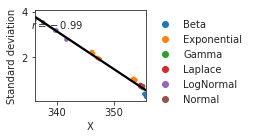

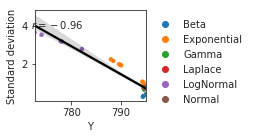

In [36]:
#Varying SD's with the other model
fname = 'Varying standard deviations_1'

sigmas = []
xy = np.empty((len(set_dist), 2))
for i in range(len(set_dist)):
    sigmas.append(set_dist[i, :, :].std().item())
    xy[i, :] = model1(set_dist[i, :, :].view(1, -1, 1)).detach().numpy()


# X
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x=xy[:,0],
                y=sigmas, 
                ax=ax,
                hue=dist_type,
                linewidth=0,
                s=20)

# correlation
r, p = stats.pearsonr(xy[:,0], sigmas)
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Standard deviation', ha='center')
ax.set_xlabel('X')

sns.regplot(x=xy[:,0], 
            y=sigmas, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

if savefigs:
    fig.savefig(os.path.join(pfp, 'scatterplotplot_X_{}.pdf'.format(fname)), dpi=600, bbox_inches='tight')
    
# Y    
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x=xy[:,1],
                y=sigmas, 
                ax=ax,
                hue=dist_type,
                linewidth=0,
                s=20)

# correlation
r, p = stats.pearsonr(xy[:,1], sigmas)
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Standard deviation', ha='center')

ax.set_xlabel('Y')

sns.regplot(x=xy[:,1], 
            y=sigmas, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)

if savefigs:
    fig.savefig('scatterplotplot_Y_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

In [21]:
dist_type = []
set_dist = []

    
for i in range(3): 
    m = torch.distributions.beta.Beta(torch.tensor([.4]), torch.tensor([0.4]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Beta')
    
for i in range(3): 
    m = torch.distributions.beta.Beta(torch.tensor([0.1]), torch.tensor([.6]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Beta')

for i in range(5): 
    m = torch.distributions.exponential.Exponential(torch.tensor([1.]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Exponential')
    
for i in range(5): 
    m = torch.distributions.exponential.Exponential(torch.tensor([0.5]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Exponential')
    
for i in range(5): 
    m = torch.distributions.gamma.Gamma(torch.tensor([0.5]), torch.tensor([1.]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Gamma')
    
for i in range(5): 
    m = torch.distributions.laplace.Laplace(torch.tensor([0.7]), torch.tensor([0.5]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('Laplace')
    
for i in range(5): 
    m = torch.distributions.log_normal.LogNormal(torch.tensor([0.5]), torch.tensor([1.]))
    x = m.sample([500])
    set_dist.append(x)
    dist_type.append('LogNormal')
    
for i in range(5): 
    m = torch.distributions.normal.Normal(torch.tensor([0.5]), torch.tensor([0.7]))
    x = m.sample([500])
    set_dist.append(x)   
    dist_type.append('Normal')
    
    
set_dist = torch.stack(set_dist)

In [26]:
fname = 'out_of_density'

results = pd.DataFrame()
euclidean_dist = []
wass_dist = []
dist_comparison = []

tic = time.time()
for i in range(len(set_dist)):
    for j in range(i+1,len(set_dist)):

        euclidean_dist.append((torch.norm(model(set_dist[i, :, :].view(1, -1, 1))-model(set_dist[j, :, :].view(1, -1, 1)), p=2)).item())
        wass_dist.append((sinkhorn(set_dist[i, :, :].view(1, -1, 1), set_dist[j, :, :].view(1, -1, 1))).item())
        dist_comparison.append('{}-{}'.format(dist_type[i], dist_type[j]))
    
    if i%50==0 and i!=0:
        print('... through {} iterations\t{:.2f}-s elapsed'.format(i+1, time.time()-tic))
        results = pd.DataFrame()
        results['Euclidean distance'] = euclidean_dist
        results['Wasserstein distance'] = wass_dist
        results['Comparisons'] = dist_comparison
        results.to_csv('results_{}.csv'.format(fname))

# store results
results = pd.DataFrame()
results['Euclidean distance'] = euclidean_dist
results['Wasserstein distance'] = wass_dist
results['Comparisons'] = dist_comparison
results.to_csv('results_{}.csv'.format(fname))

In [37]:
#Trying the other model
fname = 'out_of_density_1'

results = pd.DataFrame()
euclidean_dist = []
wass_dist = []
dist_comparison = []

tic = time.time()
for i in range(len(set_dist)):
    for j in range(i+1,len(set_dist)):

        euclidean_dist.append((torch.norm(model1(set_dist[i, :, :].view(1, -1, 1))-model1(set_dist[j, :, :].view(1, -1, 1)), p=2)).item())
        wass_dist.append((sinkhorn(set_dist[i, :, :].view(1, -1, 1), set_dist[j, :, :].view(1, -1, 1))).item())
        dist_comparison.append('{}-{}'.format(dist_type[i], dist_type[j]))
    
    if i%50==0 and i!=0:
        print('... through {} iterations\t{:.2f}-s elapsed'.format(i+1, time.time()-tic))
        results = pd.DataFrame()
        results['Euclidean distance'] = euclidean_dist
        results['Wasserstein distance'] = wass_dist
        results['Comparisons'] = dist_comparison
        results.to_csv('results_{}.csv'.format(fname))

# store results
results = pd.DataFrame()
results['Euclidean distance'] = euclidean_dist
results['Wasserstein distance'] = wass_dist
results['Comparisons'] = dist_comparison
results.to_csv('results_{}.csv'.format(fname))

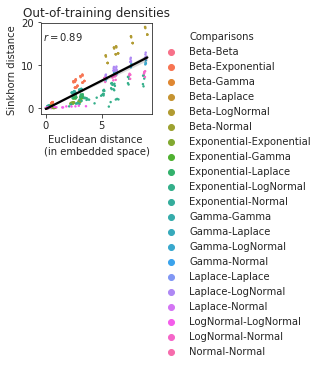

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x='Euclidean distance',
                y='Wasserstein distance',
                hue='Comparisons',
                data=results,
               # palette=dist_pal,
                linewidth=0,
                s=6,
                alpha=1,
                ax=ax,
                rasterized=True)
sns.regplot(x='Euclidean distance', 
            y='Wasserstein distance', 
            data=results, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Out-of-training densities')

# correlation
r, p = stats.pearsonr(results['Euclidean distance'], results['Wasserstein distance'])
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.set_ylabel('Sinkhorn distance ', ha='center')
ax.set_xlabel('Euclidean distance \n(in embedded space)', ha='center')

if savefigs:
    fig.savefig('corr_plot_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

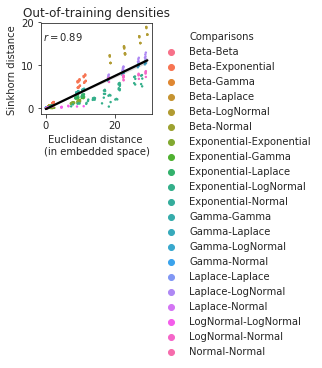

In [38]:
#Visualizing the other model 
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x='Euclidean distance',
                y='Wasserstein distance',
                hue='Comparisons',
                data=results,
               # palette=dist_pal,
                linewidth=0,
                s=6,
                alpha=1,
                ax=ax,
                rasterized=True)
sns.regplot(x='Euclidean distance', 
            y='Wasserstein distance', 
            data=results, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Out-of-training densities')

# correlation
r, p = stats.pearsonr(results['Euclidean distance'], results['Wasserstein distance'])
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.set_ylabel('Sinkhorn distance ', ha='center')
ax.set_xlabel('Euclidean distance \n(in embedded space)', ha='center')

if savefigs:
    fig.savefig('corr_plot_{}.pdf'.format(fname), dpi=600, bbox_inches='tight')

In [39]:
set_dist = []
dist_type = []

for i in range(5): 
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
    x = m.sample([250])
    set_dist.append(x) 
    dist_type.append('Normal')
    
for i in range(5): 
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([0.0, 1.0]), torch.tensor([[1,.5],[.5,1]]))
    x = m.sample([250])
    set_dist.append(x)
    dist_type.append('Normal')
    
for i in range(5): 
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.ones(2), covariance_matrix=torch.tensor([[.7,.1],[.1,1]]))
    x = m.sample([250])
    set_dist.append(x) 
    dist_type.append('Normal')
    
for i in range(5): 
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([1.0, 0.0]), torch.tensor([[.2, -.1], [-.1, 1]]))
    x = m.sample([250])
    set_dist.append(x) 
    dist_type.append('Normal')
    
for i in range(5): 
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([.5, .5]), torch.tensor([[.8,.4],[.4,1]]))
    x = m.sample([250])
    set_dist.append(x) 
    dist_type.append('Normal')
    
for i in range(5): 
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([-.25, -.5]), torch.eye(2)*.5)
    x = m.sample([250])
    set_dist.append(x) 
    dist_type.append('Normal')
    
set_dist = torch.stack(set_dist)

In [40]:
model2D = DeepSet(2,36).to(device)

checkpoint = torch.load('normal_2D_2condition1.pt')
model2D.load_state_dict(checkpoint['model_state_dict'])

model2D.eval()


DeepSet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=36, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=36, out_features=30, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [42]:
fname = '2D distributions'

results = pd.DataFrame()
euclidean_dist = []
wass_dist = []
dist_comparison = []

tic = time.time()
for i in range(len(set_dist)):
    for j in range(i+1,len(set_dist)):

        euclidean_dist.append((torch.norm(model2D(set_dist[i, :, :].view(1, -1, 2))-model2D(set_dist[j, :, :].view(1, -1, 2)), p=2)).item())
        wass_dist.append((sinkhorn(set_dist[i, :, :].view(1, -1, 2), set_dist[j, :, :].view(1, -1, 2))).item())
        dist_comparison.append('{}-{}'.format(dist_type[i], dist_type[j]))
    
    if i%50==0 and i!=0:
        print('... through {} iterations\t{:.2f}-s elapsed'.format(i+1, time.time()-tic))
        results = pd.DataFrame()
        results['Euclidean distance'] = euclidean_dist
        results['Wasserstein distance'] = wass_dist
        results['Comparisons'] = dist_comparison
        results.to_csv('results_{}.csv'.format(fname))

# store results
results = pd.DataFrame()
results['Euclidean distance'] = euclidean_dist
results['Wasserstein distance'] = wass_dist
results['Comparisons'] = dist_comparison
results.to_csv('results_{}.csv'.format(fname))

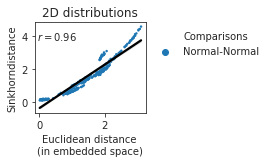

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.scatterplot(x='Euclidean distance',
                y='Wasserstein distance',
                hue='Comparisons',
                data=results,
                linewidth=0,
                s=6,
               # palette=dist_pal,
                alpha=1,
                ax=ax,
                rasterized=True)
sns.regplot(x='Euclidean distance', 
            y='Wasserstein distance', 
            data=results, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=False, fit_reg=True, ci=95, 
            n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, 
            logx=False, x_partial=None, y_partial=None, truncate=True, dropna=True, x_jitter=None, y_jitter=None, 
            label=None, color='k', marker='o', scatter_kws=None, line_kws=None, ax=ax)
ax.legend(bbox_to_anchor=(1,1))

# correlation
r, p = stats.pearsonr(results['Euclidean distance'], results['Wasserstein distance'])
ax.text(0.2,0.8,'$r={:.2f}$'.format(r), transform=ax.transAxes, ha='center')

ax.set_title(fname)
ax.set_ylabel('Sinkhorndistance', ha='center')
ax.set_xlabel('Euclidean distance \n(in embedded space)', ha='center')


if savefigs:
    fig.savefig(os.path.join(pfp, 'corr_plot_{}.pdf'.format(fname)), dpi=600, bbox_inches='tight')

In [45]:
m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2)*0.5).sample([250]).view(1, -1, 2)
mprime = m + torch.tensor([0.5, 0.5])#torch.rand(1, 2)

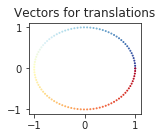

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
ax.scatter(x, y, s=1, c=counter, cmap='RdYlBu_r')
ax.set_title('Vectors for translations')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
fig.savefig(os.path.join(pfp, 'scatterplot_vectors_for_2d_translations.pdf'), bbox_inches='tight')

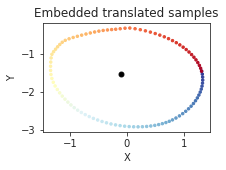

In [51]:
r = 1
n = 100
randoms = np.linspace(0,2*np.pi,n)
x,y = r*np.cos(randoms), r*np.sin(randoms)

xy = np.empty((len(randoms), 2))
counter = []
for i in range(len(randoms)):
    counter.append(i)
    xy[i, :] = model2D(m+torch.tensor([x[i],y[i]], dtype=torch.float)).detach().numpy()
    
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.scatter(model2D(m).detach()[:, 0][0], model2D(m).detach()[:, 1], color='k', s=24)
ax.scatter(xy[:, 0], xy[:, 1], c=counter, cmap='RdYlBu_r', s=6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Embedded translated samples')
fig.savefig(os.path.join(pfp, 'scatterplot_2d_translations.pdf'), bbox_to_inches='tight')

In [63]:
dist_type = []
set_dist = []

for sigma in np.linspace(0, 1, 100):
    m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([sigma]))
    x = m.sample([500])
    set_dist.append(x) 

    
set_dist = torch.stack(set_dist)

In [68]:
dirac_pt = model(torch.zeros((1, 500, 1))).detach().numpy()
xy = model(set_dist).detach().numpy()

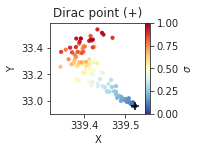

In [69]:
fig, ax = plt.subplots(1,1, figsize=(2, 1.67))
im = ax.scatter(xy[:, 0], xy[:, 1], c=np.linspace(0, 1, 100), cmap='RdYlBu_r', s=10)
fig.colorbar(im, pad=0, label='$\sigma$')
ax.scatter(dirac_pt[:, 0], dirac_pt[:, 1], color='black', marker='+', s=50)
ax.set_title('Dirac point (+)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.savefig(os.path.join(pfp, 'scatterplot_dirac_pt.pdf'), bbox_inches='tight')

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity  # display as density curves
import torch
from geomloss import SamplesLoss

In [54]:
N, M = (500, 500)
t_i = torch.linspace(0, 1, M).view(-1,1)
t_j = torch.linspace(0, 1, M).view(-1,1)
X_i, Y_j  = .1 * t_i, .2 * t_j + .8  # Intervals [0., 0.1] and [.8, 1.]
t_k = torch.linspace(0, 1, N).view(-1,1)
Z_k = t_k

In [55]:
import matplotlib
from math import isnan
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore",".*GUI is implemented.*") # annoying warning with pyplot and pause...

def mypause(interval):
    """Pause matplotlib without stealing focus."""
    backend = plt.rcParams['backend']
    if backend in matplotlib.rcsetup.interactive_bk:
        figManager = matplotlib._pylab_helpers.Gcf.get_active()
        if figManager is not None:
            canvas = figManager.canvas
            if canvas.figure.stale:
                canvas.draw()
            canvas.start_event_loop(interval)
            return


def model_to_numpy(model, grad=False) :
    """
    The fortran routines used by scipy.optimize expect float64 vectors
    instead of the gpu-friendly float32 matrices: we need conversion routines.
    """
    if not all( param.is_contiguous() for param in model.parameters() ) :
        raise ValueError("Scipy optimization routines are only compatible with parameters given as *contiguous* tensors.")

    if grad :
        tensors = [param.grad.data.view(-1).cpu().numpy() for param in model.parameters()]
    else :
        tensors = [param.data.view(-1).cpu().numpy()      for param in model.parameters()]
    return np.ascontiguousarray( np.hstack(tensors) , dtype='float64' )

def numpy_to_model(model, vec) :
    i = 0
    for param in model.parameters() :
        offset = param.numel()
        param.data = torch.from_numpy(vec[i:i+offset]).view(param.data.size()).type(param.data.type())
        i += offset

    if i != len(vec) :
        raise ValueError("The total number of variables in model is not the same as in 'vec'.")

def fit_model(Model, method = "L-BFGS", tol = 1e-10, nits = 500, nlogs = 10,
                     lr = .1, eps = .01, maxcor = 10, gtol = 1e-10, 
                     display = False, **params) :
    """
    """

    # Load parameters =====================================================================================================


    # We'll minimize the model's cost
    # with respect to the model's parameters using a standard gradient-like
    # descent scheme. As we do not perform any kind of line search, 
    # this algorithm may diverge if the learning rate is too large !
    # For robust optimization routines, you may consider using
    # the scipy.optimize API with a "parameters <-> float64 vector" wrapper.
    use_scipy = False
    if method == "Adam" :
        optimizer = torch.optim.Adam(Model.parameters(), lr=lr, eps=eps)
    elif method == "L-BFGS" :
        optimizer = torch.optim.SGD(Model.parameters(), lr=1.) # We'll just use its "zero_grad" method...

        use_scipy = True
        method    = 'L-BFGS-B'
        options   = dict( maxiter = nits,
                          ftol    = tol,          # Don't bother fitting the shapes to float precision
                          gtol    = gtol,
                          maxcor  = maxcor        # Number of previous gradients used to approximate the Hessian
                    )
    else :
        raise NotImplementedError('Optimization method not supported : "'+method+'". '\
                                  'Available values are "Adam" and "L-BFGS".')

    costs = []
    # Define the "closures" associated to our model =======================================================================

    fit_model.nit = -1 ; fit_model.breakloop = False
    def closure(final_it=False):
        """
        Encapsulates a problem + display iteration into a single callable statement.
        This wrapper is needed if you choose to use LBFGS-like algorithms, which
        (should) implement a careful line search along the gradient's direction.
        """
        fit_model.nit += 1 ; it = fit_model.nit
        # Minimization loop --------------------------------------------------------------------
        optimizer.zero_grad()                      # Reset the gradients (PyTorch syntax...).
        cost = Model.forward()
        costs.append(cost.item())  # Store the "cost" for plotting.
        cost.backward()            # Backpropagate to compute the gradient.
        # Break the loop if the cost's variation is below the tolerance param:
        if ( len(costs)>1 and abs(costs[-1]-costs[-2]) < tol ) or fit_model.nit == nits-1:
            fit_model.breakloop = True
        
        if display:

            Model.plot(nit=fit_model.nit, cost=cost.item())
            # print("{}: {:2.4f}".format(fit_model.nit, cost.item()))
        return cost
    
    # Scipy-friendly wrapper ------------------------------------------------------------------------------------------------
    def numpy_closure(vec, final_it=False) :
        """
        Wraps the PyTorch closure into a 'float64'-vector routine,
        as expected by scipy.optimize.
        """
        vec    = lr * vec.astype('float64')            # scale the vector, and make sure it's given as float64
        numpy_to_model(Model, vec)                     # load this info into Model's parameters
        c      = closure(final_it).item()              # compute the cost and accumulate the gradients wrt. the parameters
        dvec_c = lr * model_to_numpy(Model, grad=True) # -> return this gradient, as a properly rescaled numpy vector
        return (c, dvec_c)

    # Actual minimization loop ===============================================================================================
    if use_scipy :
        res = minimize( numpy_closure,      # function to minimize
                model_to_numpy(Model), # starting estimate
                method  = method,
                jac     = True,             # matching_problems also returns the gradient
                options = options    )
        numpy_closure(res.x, final_it=True) 
        # print(res.message)
    else :
        for i in range(nits+1) :            # Fixed number of iterations
            optimizer.step(closure)         # "Gradient descent" step.
            if fit_model.breakloop :
                closure(final_it=True) 
                break
            

In [59]:
t_plot = np.linspace(-0.1, 1.1, 1000)[:,np.newaxis]

def display_samples(ax, x, color, weights=None, blur=.002):
    """Displays samples on the unit interval using a density curve."""
    kde  = KernelDensity(kernel='gaussian', bandwidth= blur ).fit(
            x.data.cpu().numpy(), 
            sample_weight = None if weights is None else weights.data.cpu().numpy())
    dens = np.exp( kde.score_samples(t_plot) )
    dens[0] = 0 ; dens[-1] = 0
    ax.fill(t_plot, dens, color=color)

In [60]:
class Barycenter(nn.Module):
    """Abstract model for the computation of Sinkhorn barycenters."""

    def __init__(self, loss, w=.5):
        super(Barycenter, self).__init__()
        self.loss = loss   # Sinkhorn divergence to optimize
        self.w = w         # Interpolation coefficient
        # We copy the reference starting points, to prevent in-place modification:
        self.x_i, self.y_j, self.z_k = X_i.clone(), Y_j.clone(), Z_k.clone()

    def fit(self, display=False, tol=1e-10):
        """Uses a custom wrapper around the scipy.optimize module."""
        fit_model(self, method = "L-BFGS", lr = 1., display = display, tol=tol, gtol=tol)

    def weights(self):
        """The default weights are uniform, equal to 1/N."""
        return (torch.ones(len(self.z_k)) / len(self.z_k)).type_as(self.z_k)

    def plot(self, nit=0, cost=0, ax=None, title=None):
        """Displays the descent using a custom 'waffle' layout.

        N.B.: As the L-BFGS descent typically induces high-frequencies in
              the optimization process, we blur the 'interpolating' measure
              a little bit more than the two endpoints.
        """
        if ax is None:
            if nit == 0 or nit % 16 == 4:
                plt.pause(.01)
                plt.figure(figsize=(16,4))

            if nit <= 4 or nit % 4 == 0:
                if nit < 4: index = nit + 1
                else:       index = (nit//4 - 1) % 4 + 1
                ax = plt.subplot(1,4, index)

        if ax is not None:
            display_samples(ax, self.x_i, (.95,.55,.55))
            display_samples(ax, self.y_j, (.55,.55,.95))
            display_samples(ax, self.z_k, (.55,.95,.55), weights = self.weights(), blur=.005)

            if title is None:
                ax.set_title("nit = {}, cost = {:3.4f}".format(nit, cost))
            else:
                ax.set_title(title)

            ax.axis([-.1,1.1,-.1,20.5])
            ax.set_xticks([], []); ax.set_yticks([], [])
            plt.tight_layout()


class EulerianBarycenter(Barycenter) :
    """Barycentric model with fixed locations z_k, as we optimize on the log-weights l_k."""
    def __init__(self, loss, w=.5) :
        super(EulerianBarycenter, self).__init__(loss, w)

        # We're going to work with variable weights, so we should explicitely
        # define the (uniform) weights on the "endpoint" samples:
        self.a_i = (torch.ones(len(self.x_i)) / len(self.x_i)).type_as(self.x_i)
        self.b_j = (torch.ones(len(self.y_j)) / len(self.y_j)).type_as(self.y_j)

        # Our parameter to optimize: the logarithms of our weights
        self.l_k = nn.Parameter( torch.zeros(len(self.z_k)).type_as(self.z_k) )

    def weights(self):
        """Turns the l_k's into the weights of a positive probabilty measure."""
        return torch.nn.functional.softmax(self.l_k, dim=0)

    def forward(self) :
        """Returns the cost to minimize."""
        c_k  = self.weights()
        return self.w  * self.loss(c_k, self.z_k, self.a_i, self.x_i) \
        + (1 - self.w) * self.loss(c_k, self.z_k, self.b_j, self.y_j)

In [61]:
Eb = EulerianBarycenter( SamplesLoss("sinkhorn", blur=.001, scaling=.99) )

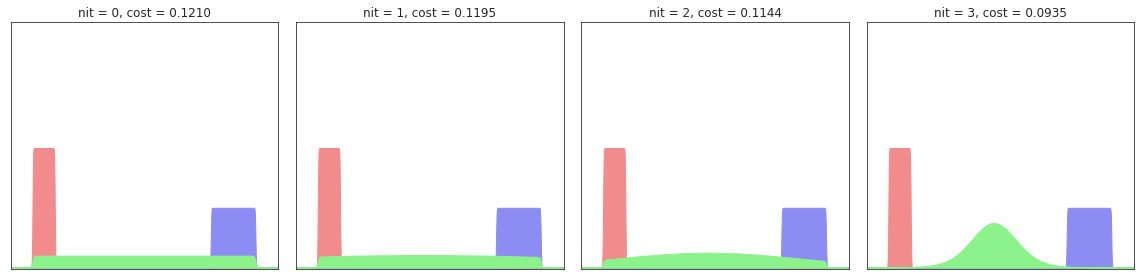

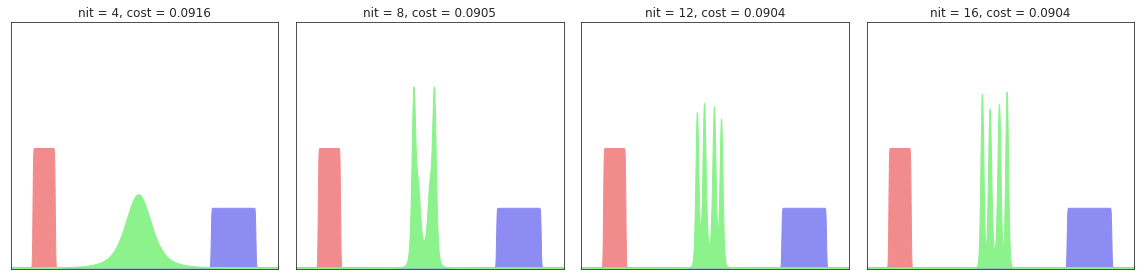

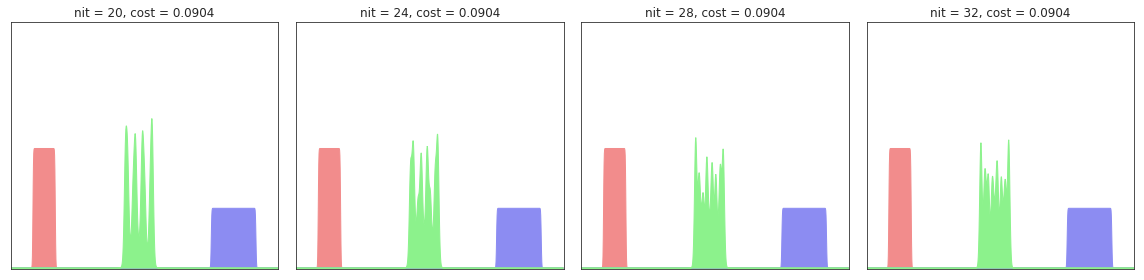

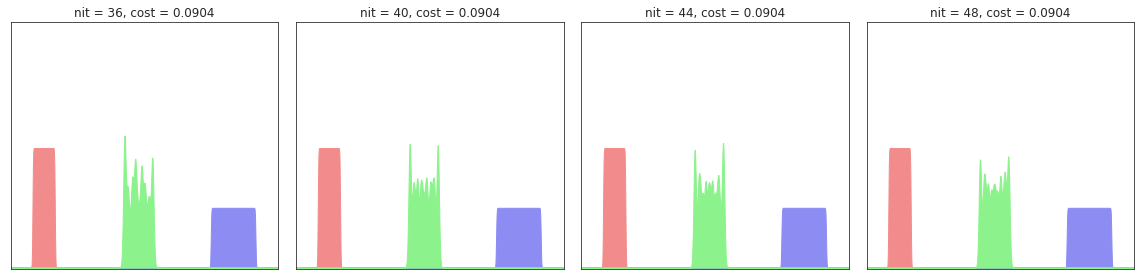

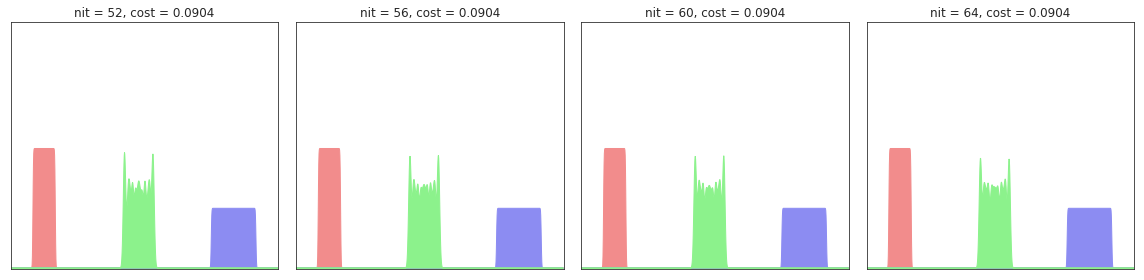

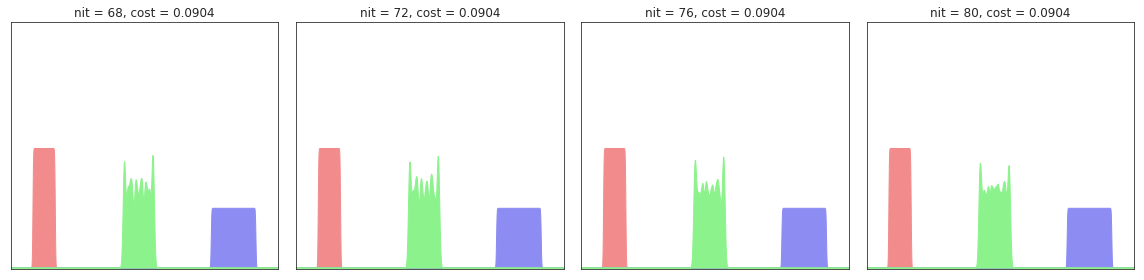

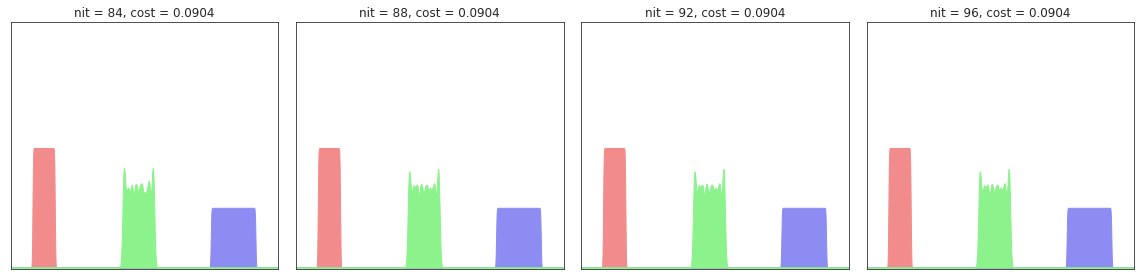

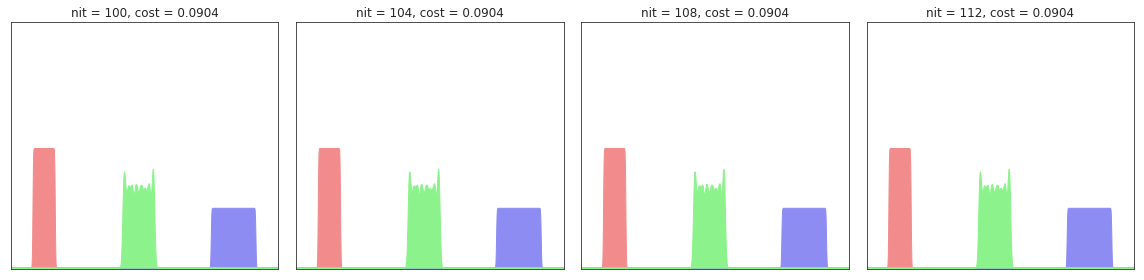

KeyboardInterrupt: 

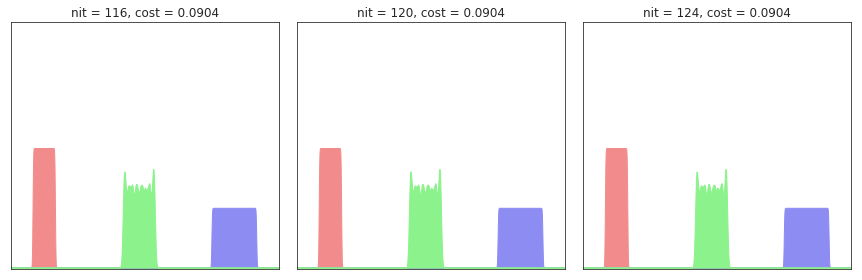

In [62]:
Eb.fit(display=True)

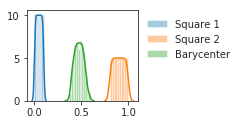

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.distplot(X_i, label='Square 1', ax = ax)
sns.distplot(Y_j, label='Square 2', ax = ax)

# get barycenter
weights = torch.nn.functional.softmax(Eb.l_k, dim=0)
kde = KernelDensity(kernel='gaussian', bandwidth= .02).fit(Eb.z_k.numpy(),
            sample_weight = weights.detach().numpy())
z_sampled = kde.sample(500) 
sns.distplot(z_sampled, label='Barycenter', ax=ax)
ax.legend(bbox_to_anchor=(1,1))

fig.savefig(os.path.join(pfp, 'barycenter_squares.pdf'), bbox_inches='tight')

In [75]:
embeddings.loc[0,'X'] = 1

In [78]:
embeddings = pd.DataFrame(columns = ['X', 'Y'])
embeddings.loc['Square-1', ['X', 'Y']] = model(X_i.view(1, -1, 1)).detach().numpy()
embeddings.loc['Square-2', ['X', 'Y']] = model(Y_j.view(1, -1, 1)).detach().numpy()
embeddings.loc['Barycenter (squares)', ['X', 'Y']] = model(torch.tensor(z_sampled, dtype=torch.float).view(1, -1, 1)).detach().numpy()

In [95]:
embeddings1 = pd.DataFrame(columns = ['X', 'Y'])
embeddings1.loc['Square-1', ['X', 'Y']] = model1(X_i.view(1, -1, 1)).detach().numpy()
embeddings1.loc['Square-2', ['X', 'Y']] = model1(Y_j.view(1, -1, 1)).detach().numpy()
embeddings1.loc['Barycenter (squares)', ['X', 'Y']] = model1(torch.tensor(z_sampled, dtype=torch.float).view(1, -1, 1)).detach().numpy()

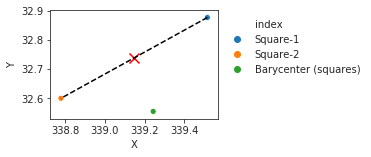

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.plot([embeddings.loc['Square-1', 'X'], embeddings.loc['Square-2', 'X']],
         [embeddings.loc['Square-1', 'Y'], embeddings.loc['Square-2', 'Y']],
        'k--')
ax.scatter((embeddings.loc['Square-1', 'X'] + embeddings.loc['Square-2', 'X'])/2,
            (embeddings.loc['Square-1', 'Y'] + embeddings.loc['Square-2', 'Y'])/2,
           color='r', marker='x', s=100)

sns.scatterplot(x='X', y='Y',
                hue='index', 
                data=embeddings.reset_index(),
                ax=ax)
ax.legend(bbox_to_anchor=(1,1))
fig.savefig(os.path.join(pfp, 'barycenter_embedding+midpt.pdf'),  bbox_inches='tight')

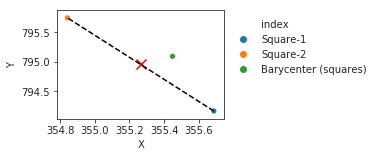

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(3,2))
ax.plot([embeddings1.loc['Square-1', 'X'], embeddings1.loc['Square-2', 'X']],
         [embeddings1.loc['Square-1', 'Y'], embeddings1.loc['Square-2', 'Y']],
        'k--')
ax.scatter((embeddings1.loc['Square-1', 'X'] + embeddings1.loc['Square-2', 'X'])/2,
            (embeddings1.loc['Square-1', 'Y'] + embeddings1.loc['Square-2', 'Y'])/2,
           color='r', marker='x', s=100)

sns.scatterplot(x='X', y='Y',
                hue='index', 
                data=embeddings1.reset_index(),
                ax=ax)
ax.legend(bbox_to_anchor=(1,1))
fig.savefig(os.path.join(pfp, 'barycenter_embedding_1+midpt.pdf'),  bbox_inches='tight')

In [81]:
X_i, Y_j  = torch.zeros(500).view(-1, 1), torch.ones(500).view(-1, 1)# Intervals [0., 0.1] and [.8, 1.].

t_k = torch.linspace(-.1, 1.1, 500).view(-1,1)
Z_k = t_k

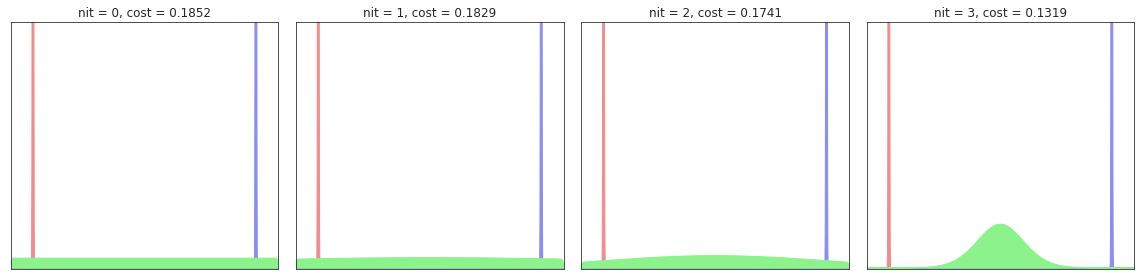

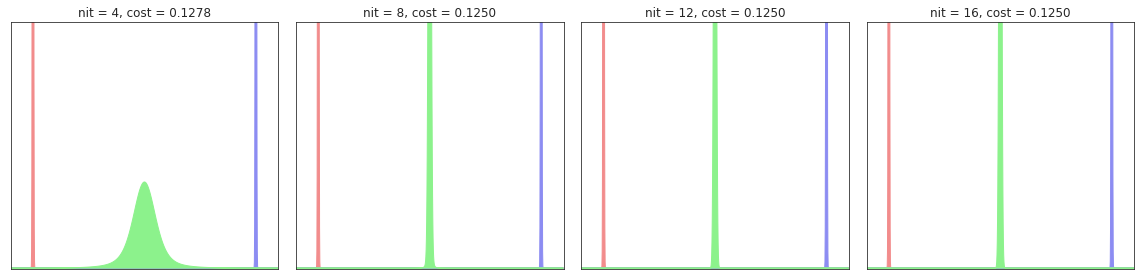

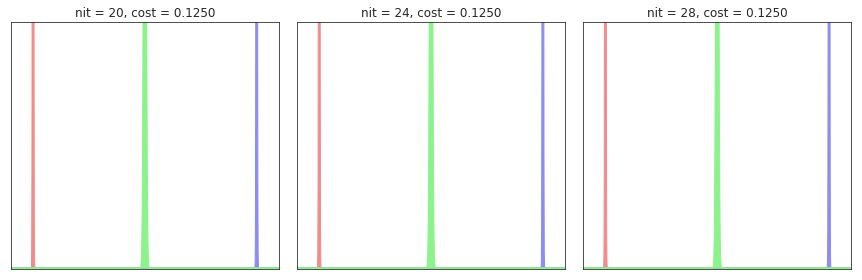

In [83]:
EB = EulerianBarycenter( SamplesLoss("sinkhorn", blur=.001, scaling=.99) )
EB.fit(display=True)

/gpfs/ysm/project/dijk/as3837/conda_envs/py37_dev/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


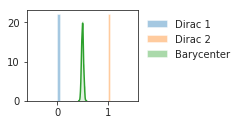

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.distplot(X_i, label='Dirac 1', ax = ax)
sns.distplot(Y_j, label='Dirac 2', ax = ax)

# get barycenter
weights = torch.nn.functional.softmax(EB.l_k, dim=0)
kde = KernelDensity(kernel='gaussian', bandwidth= .02).fit(EB.z_k.numpy(),
            sample_weight = weights.detach().numpy())
z_sampled = kde.sample(500) 
sns.distplot(z_sampled, label='Barycenter', ax=ax)
ax.legend(bbox_to_anchor=(1,1))

fig.savefig(os.path.join(pfp, 'barycenter_dirac.pdf'), bbox_inches='tight')

In [85]:
embeddings.loc['Dirac-1', ['X', 'Y']] = model(X_i.view(1, -1, 1)).detach().numpy()
embeddings.loc['Dirac-2', ['X', 'Y']] = model(Y_j.view(1, -1, 1)).detach().numpy()
embeddings.loc['Barycenter (Diracs)', ['X', 'Y']] = model(torch.tensor(z_sampled, dtype=torch.float).view(1, -1, 1)).detach().numpy()

In [97]:
embeddings1.loc['Dirac-1', ['X', 'Y']] = model1(X_i.view(1, -1, 1)).detach().numpy()
embeddings1.loc['Dirac-2', ['X', 'Y']] = model1(Y_j.view(1, -1, 1)).detach().numpy()
embeddings1.loc['Barycenter (Diracs)', ['X', 'Y']] = model1(torch.tensor(z_sampled, dtype=torch.float).view(1, -1, 1)).detach().numpy()

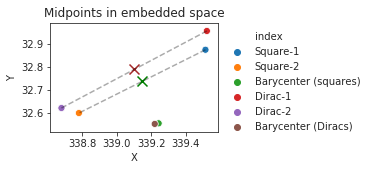

In [86]:
# plot the embedded space 67trrrf55
fig, ax = plt.subplots(1, 1, figsize=(3,2))

# squares
ax.plot([embeddings.loc['Square-1', 'X'], embeddings.loc['Square-2', 'X']],
         [embeddings.loc['Square-1', 'Y'], embeddings.loc['Square-2', 'Y']],
        'k--', alpha=0.33)
ax.scatter((embeddings.loc['Square-1', 'X'] + embeddings.loc['Square-2', 'X'])/2,
            (embeddings.loc['Square-1', 'Y'] + embeddings.loc['Square-2', 'Y'])/2,
           color='green', marker='x', s=100)

# diracs
ax.plot([embeddings.loc['Dirac-1', 'X'], embeddings.loc['Dirac-2', 'X']],
         [embeddings.loc['Dirac-1', 'Y'], embeddings.loc['Dirac-2', 'Y']],
        'k--', alpha=0.33)
ax.scatter((embeddings.loc['Dirac-1', 'X'] + embeddings.loc['Dirac-2', 'X'])/2,
            (embeddings.loc['Dirac-1', 'Y'] + embeddings.loc['Dirac-2', 'Y'])/2,
           color='brown', marker='x', s=100)

sns.scatterplot(x='X', y='Y',
                hue='index', 
                data=embeddings.reset_index(),
                ax=ax,
                s=50)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Midpoints in embedded space')
fig.savefig(os.path.join(pfp, 'barycenter_embedding+midpt.pdf'),  bbox_inches='tight')

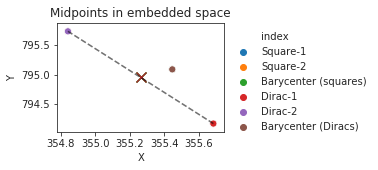

In [98]:
# plot the embedded space 67trrrf55
fig, ax = plt.subplots(1, 1, figsize=(3,2))

# squares
ax.plot([embeddings1.loc['Square-1', 'X'], embeddings1.loc['Square-2', 'X']],
         [embeddings1.loc['Square-1', 'Y'], embeddings1.loc['Square-2', 'Y']],
        'k--', alpha=0.33)
ax.scatter((embeddings1.loc['Square-1', 'X'] + embeddings1.loc['Square-2', 'X'])/2,
            (embeddings1.loc['Square-1', 'Y'] + embeddings1.loc['Square-2', 'Y'])/2,
           color='green', marker='x', s=100)

# diracs
ax.plot([embeddings1.loc['Dirac-1', 'X'], embeddings1.loc['Dirac-2', 'X']],
         [embeddings1.loc['Dirac-1', 'Y'], embeddings1.loc['Dirac-2', 'Y']],
        'k--', alpha=0.33)
ax.scatter((embeddings1.loc['Dirac-1', 'X'] + embeddings1.loc['Dirac-2', 'X'])/2,
            (embeddings1.loc['Dirac-1', 'Y'] + embeddings1.loc['Dirac-2', 'Y'])/2,
           color='brown', marker='x', s=100)

sns.scatterplot(x='X', y='Y',
                hue='index', 
                data=embeddings1.reset_index(),
                ax=ax,
                s=50)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Midpoints in embedded space')
fig.savefig(os.path.join(pfp, 'barycenter_embedding_1+midpt.pdf'),  bbox_inches='tight')

In [87]:
m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.1]))
N = torch.distributions.normal.Normal(torch.tensor([1.]), torch.tensor([0.1]))

In [88]:
X_i, Y_j = m.sample([500]).view(-1,1), N.sample([500]).view(-1,1)


t_k = torch.linspace(-2, 2, 500).view(-1,1)
Z_k = t_k

In [91]:
EB = EulerianBarycenter(SamplesLoss("sinkhorn", p=2, blur=.001, scaling=.99))
EB.fit(display=False)

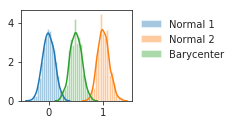

In [92]:
# get distributions out 
fig, ax = plt.subplots(1, 1, figsize=(2, 1.67))
sns.distplot(X_i, label='Normal 1', ax = ax)
sns.distplot(Y_j, label='Normal 2', ax = ax)

# get barycenter
weights = torch.nn.functional.softmax(EB.l_k, dim=0)
kde = KernelDensity(kernel='gaussian', bandwidth= .02).fit(EB.z_k.numpy(),
            sample_weight = weights.detach().numpy())
z_sampled = kde.sample(500) 
sns.distplot(z_sampled, label='Barycenter', ax=ax)
ax.legend(bbox_to_anchor=(1,1))

fig.savefig(os.path.join(pfp, 'barycenter_normals.pdf'), bbox_inches='tight')

In [93]:
embeddings.loc['Normal-1', ['X', 'Y']] = model(X_i.view(1, -1, 1)).detach().numpy()
embeddings.loc['Normal-2', ['X', 'Y']] = model(Y_j.view(1, -1, 1)).detach().numpy()
embeddings.loc['Barycenter (Normals)', ['X', 'Y']] = model(torch.tensor(z_sampled, dtype=torch.float).view(1, -1, 1)).detach().numpy()

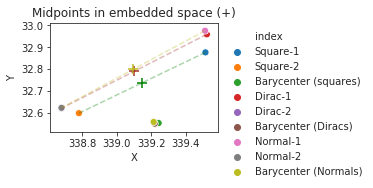

In [94]:

fig, ax = plt.subplots(1, 1, figsize=(3,2))

# squares
ax.plot([embeddings.loc['Square-1', 'X'], embeddings.loc['Square-2', 'X']],
         [embeddings.loc['Square-1', 'Y'], embeddings.loc['Square-2', 'Y']],
         color='green', linestyle='--', alpha=0.33)
ax.scatter((embeddings.loc['Square-1', 'X'] + embeddings.loc['Square-2', 'X'])/2,
            (embeddings.loc['Square-1', 'Y'] + embeddings.loc['Square-2', 'Y'])/2,
           color='green', marker='+', s=100)

# diracs
ax.plot([embeddings.loc['Dirac-1', 'X'], embeddings.loc['Dirac-2', 'X']],
         [embeddings.loc['Dirac-1', 'Y'], embeddings.loc['Dirac-2', 'Y']],
        color='brown', linestyle='--', alpha=0.33)
ax.scatter((embeddings.loc['Dirac-1', 'X'] + embeddings.loc['Dirac-2', 'X'])/2,
            (embeddings.loc['Dirac-1', 'Y'] + embeddings.loc['Dirac-2', 'Y'])/2,
           color='brown', marker='+', s=100)

# normals
ax.plot([embeddings.loc['Normal-1', 'X'], embeddings.loc['Normal-2', 'X']],
         [embeddings.loc['Normal-1', 'Y'], embeddings.loc['Normal-2', 'Y']],
        color=sns.color_palette()[8],
        linestyle='--', alpha=0.33)
ax.scatter((embeddings.loc['Normal-1', 'X'] + embeddings.loc['Normal-2', 'X'])/2,
            (embeddings.loc['Normal-1', 'Y'] + embeddings.loc['Normal-2', 'Y'])/2,
           color=sns.color_palette()[8], marker='+', s=100)

sns.scatterplot(x='X', y='Y',
                hue='index', 
                data=embeddings.reset_index(),
                ax=ax,
                s=50)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Midpoints in embedded space (+)')
fig.savefig(os.path.join(pfp, 'barycenter_embedding+midpt.pdf'),  bbox_inches='tight')

In [99]:
embeddings1.loc['Normal-1', ['X', 'Y']] = model1(X_i.view(1, -1, 1)).detach().numpy()
embeddings1.loc['Normal-2', ['X', 'Y']] = model1(Y_j.view(1, -1, 1)).detach().numpy()
embeddings1.loc['Barycenter (Normals)', ['X', 'Y']] = model1(torch.tensor(z_sampled, dtype=torch.float).view(1, -1, 1)).detach().numpy()

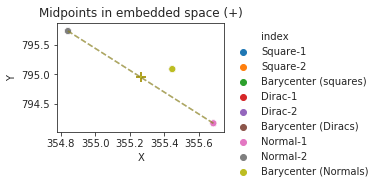

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(3,2))

# squares
ax.plot([embeddings1.loc['Square-1', 'X'], embeddings1.loc['Square-2', 'X']],
         [embeddings1.loc['Square-1', 'Y'], embeddings1.loc['Square-2', 'Y']],
         color='green', linestyle='--', alpha=0.33)
ax.scatter((embeddings1.loc['Square-1', 'X'] + embeddings1.loc['Square-2', 'X'])/2,
            (embeddings1.loc['Square-1', 'Y'] + embeddings1.loc['Square-2', 'Y'])/2,
           color='green', marker='+', s=100)

# diracs
ax.plot([embeddings1.loc['Dirac-1', 'X'], embeddings1.loc['Dirac-2', 'X']],
         [embeddings1.loc['Dirac-1', 'Y'], embeddings1.loc['Dirac-2', 'Y']],
        color='brown', linestyle='--', alpha=0.33)
ax.scatter((embeddings1.loc['Dirac-1', 'X'] + embeddings1.loc['Dirac-2', 'X'])/2,
            (embeddings1.loc['Dirac-1', 'Y'] + embeddings1.loc['Dirac-2', 'Y'])/2,
           color='brown', marker='+', s=100)

# normals
ax.plot([embeddings1.loc['Normal-1', 'X'], embeddings1.loc['Normal-2', 'X']],
         [embeddings1.loc['Normal-1', 'Y'], embeddings1.loc['Normal-2', 'Y']],
        color=sns.color_palette()[8],
        linestyle='--', alpha=0.33)
ax.scatter((embeddings1.loc['Normal-1', 'X'] + embeddings1.loc['Normal-2', 'X'])/2,
            (embeddings1.loc['Normal-1', 'Y'] + embeddings1.loc['Normal-2', 'Y'])/2,
           color=sns.color_palette()[8], marker='+', s=100)

sns.scatterplot(x='X', y='Y',
                hue='index', 
                data=embeddings1.reset_index(),
                ax=ax,
                s=50)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Midpoints in embedded space (+)')
fig.savefig(os.path.join(pfp, 'barycenter_embedding_1+midpt.pdf'),  bbox_inches='tight')